In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import torch
from torch.autograd import Variable
from FuseNet import FuseNet, CrossEntropy2d
from Solver_FuseNet import Solver_SS
import torch.nn.functional as F
from utils.data_utils_class import get_data

from dataloaders.NYUDv2Loader import *
from dataloaders.SUNRGBDLoader import *

%matplotlib inline
from utils.visual_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
def evaluate(model, num_classes, val_loader, data_type):
    # Calculate IoU and Mean accuracies
    print num_classes
    val_confusion = np.zeros((num_classes,3))
    IoU = 0
    mean_acc = 0

    for batch in val_loader:
        val_rgb_inputs  = Variable(batch[0].cuda(gpu_device))
        val_d_inputs    = Variable(batch[1].cuda(gpu_device))
        val_labels      = Variable(batch[2].cuda(gpu_device))
        val_outputs     = model(val_rgb_inputs, val_d_inputs)
        _, val_preds    = torch.max	(val_outputs, 1)

        if (data_type == 'sun' or data_type == 'SUN'):
            val_labels = val_labels - 1     # sun
        elif (data_type == 'nyu' or data_type == 'NYU'):
            val_preds = val_preds + 1       # nyu

        for i in range(num_classes):
            val_labels_mask = val_labels == i
            val_preds_mask = val_preds == i
            TP = np.sum((val_preds == val_labels)[val_labels_mask].data.cpu().numpy())
            #print TP
            val_confusion[i,0] += TP 
            val_confusion[i,1] += np.sum((val_labels==val_labels)[val_labels_mask].data.cpu().numpy()) - TP 
            val_confusion[i,2] += np.sum((val_preds==val_preds)[val_preds_mask].data.cpu().numpy()) - TP 

    for i in range(num_classes):
        TP, FP, FN = val_confusion[i]
        print(TP+FP,FN)
        IoU += TP / (TP + FP + FN)
        mean_acc += TP / (TP + FP)
    IoU /= num_classes
    mean_acc /= num_classes

    print("        Best VALIDATION IoU: %.3f Mean Accuracy: %.3f" % (IoU, mean_acc))

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
data_visualizer = DataVisualizer()

# NYUDv2

In [5]:
gpu_device = 1
num_classes_nyu = 13

In [6]:
v_loader_nyu = NYUDv2Loader(gpu_device, '/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_nyu = data.DataLoader(v_loader_nyu, batch_size=4, num_workers=16)

In [7]:
model_nyu = FuseNet(gpu_device, num_classes_nyu).cuda()
checkpoint = torch.load('../models/nyu/checkpoint25.pth.tar')
model_nyu.load_state_dict(checkpoint['state_dict']) 

In [8]:
sampling_position = 0
for n, sample in enumerate(val_loader_nyu):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_nyu(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    val_preds = val_preds + 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  2  3  5  6  7  8  9 10 12 13]
[ 1  2  3  4  5  6  7  8  9 10 12 13]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff90b1cf890>> ignored


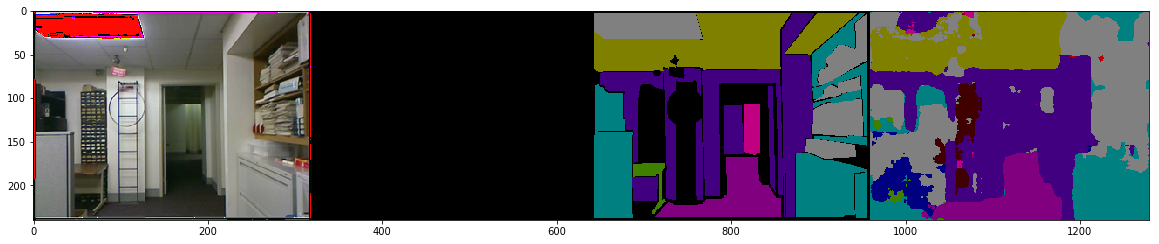

In [10]:
idx = 2
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=False)

In [12]:
evaluate(model_nyu, num_classes_nyu, val_loader_nyu)

13
(2048477.0, 451611.0)
(330180.0, 109837.0)
(645770.0, 360990.0)
(1640338.0, 1090261.0)
(4915685.0, 1346497.0)
(6972920.0, 4021969.0)
(6070799.0, 4205092.0)
(1104096.0, 626607.0)
(1542769.0, 694780.0)
(1778309.0, 1106874.0)
(212285.0, 89222.0)
(11829309.0, 4909909.0)
(2546211.0, 1009791.0)
        Best VALIDATION IoU: 0.424 Mean Accuracy: 0.619


# SUNRGBD

In [11]:
gpu_device = 1
num_classes_sun = 38

In [12]:
v_loader_sun = SUNRGBDLoader(gpu_device, '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_sun = data.DataLoader(v_loader_sun, batch_size=4, num_workers=16)

In [13]:
model_sun = FuseNet(gpu_device, num_classes_sun).cuda()
checkpoint = torch.load('../models/sun/checkpoint25.pth.tar')
model_sun.load_state_dict(checkpoint['state_dict']) 

In [14]:
sampling_position = 14
for n, sample in enumerate(val_loader_sun):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_sun(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    labels = labels - 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  1  2  4  5  6  7  9 10 11 16 21 23 26 35 37]
[ 0  1  2  3  5  6  7  8  9 11 16 17 18 22 25 35]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff90b1d1b10>> ignored


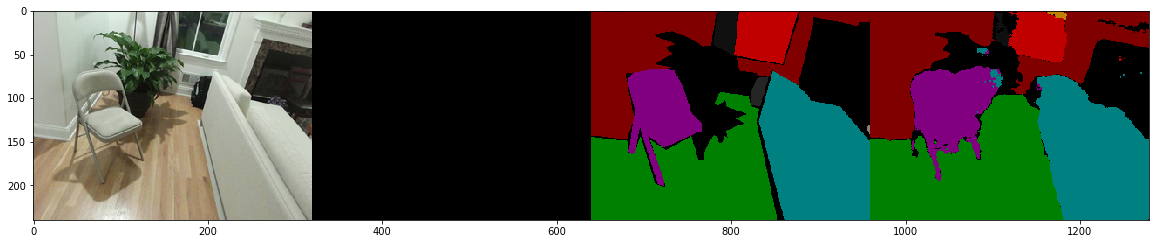

In [16]:
idx = 2
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=False)

In [16]:
evaluate(model_sun, num_classes_sun, val_loader_sun, 'sun')

38
(100380819.0, 71372922.0)
(76950380.0, 32245691.0)
(66248050.0, 11833969.0)
(8192273.0, 950750.0)
(8423890.0, 3645829.0)
(30644096.0, 9511971.0)
(8244155.0, 1866620.0)
(24590411.0, 14160683.0)
(8046135.0, 1597191.0)
(8101946.0, 5249958.0)
(2579317.0, 12449.0)
(2263473.0, 331680.0)
(2701786.0, 434967.0)
(1273099.0, 98251.0)
(9681808.0, 18180.0)
(1101587.0, 0.0)
(3573950.0, 1342217.0)
(1858656.0, 334570.0)
(1627987.0, 225559.0)
(1528022.0, 19671.0)
(190924.0, 0.0)
(1306164.0, 0.0)
(3125932.0, 2352562.0)
(1578584.0, 0.0)
(1543665.0, 0.0)
(552957.0, 1089.0)
(1227810.0, 12663.0)
(579606.0, 0.0)
(154372.0, 0.0)
(2292851.0, 0.0)
(2034632.0, 780630.0)
(330616.0, 0.0)
(192364.0, 0.0)
(979421.0, 29803.0)
(1372099.0, 218441.0)
(762264.0, 45642.0)
(602312.0, 10015.0)
(924787.0, 0.0)
        Best VALIDATION IoU: 0.143 Mean Accuracy: 0.195
